In [346]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [347]:
import warnings
warnings.filterwarnings("ignore")

### Load Data

In [348]:
from glob import glob 
glob('./*')

['./Predict_bad_loan.ipynb',
 './Loan_Dataset_3.csv',
 './Loan_Dataset.csv',
 './Predict_bad_loan_cont_(Unsupervised_&_Supervised_approach).ipynb',
 './Loan_Dataset_2.csv',
 './bad_data.csv',
 './Predict_bad_loan_cont_(Dimensionality_Reduction_approach).ipynb',
 './Predict_bad_loan_cont_Anomaly_Detection_questionable_data?.ipynb',
 './Predict_bad_loan_cont_Anomaly_Detection_final_notebook.ipynb',
 './Predict_bad_loan_cont_Anomaly_Detection_disregard.ipynb',
 './variable_descriptions',
 './Predict_bad_loan_cont_Anomaly_Detection_good_data?.ipynb',
 './good_data.csv']

In [349]:
df = pd.read_csv('Loan_Dataset.csv')

In [350]:
df.head()

,id,grade,annual_income,short_employee,emp_length_num,home_ownership,Debt-To-Income Ratio,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
0,11454641,A,100000,1,1,RENT,26.27,credit_card,36 months,1,NaN,43.2,0.0,0.160624,0
1,9604874,A,83000,0,4,OWN,5.39,credit_card,36 months,0,NaN,21.5,0.0,0.810777,0
2,9684700,D,78000,0,11,MORTGAGE,18.45,debt_consolidation,60 months,1,NaN,46.3,0.0,0.035147,1
3,9695736,D,37536,0,6,MORTGAGE,12.28,medical,60 months,0,NaN,10.7,0.0,0.534887,1
4,9795013,D,65000,0,11,MORTGAGE,11.26,debt_consolidation,36 months,0,NaN,15.2,0.0,0.166500,0


In [351]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     20000 non-null  int64  
 1   grade                  20000 non-null  object 
 2   annual_income          20000 non-null  int64  
 3   short_employee         20000 non-null  int64  
 4   emp_length_num         20000 non-null  int64  
 5   home_ownership         18509 non-null  object 
 6   Debt-To-Income Ratio   19846 non-null  float64
 7   purpose                20000 non-null  object 
 8   term                   20000 non-null  object 
 9   last_delinq_none       20000 non-null  int64  
 10  last_major_derog_none  574 non-null    float64
 11  revol_util             20000 non-null  float64
 12  total_rec_late_fee     20000 non-null  float64
 13  od_ratio               20000 non-null  float64
 14  bad_loan               20000 non-null  int64  
dtypes:

### Data Cleaning - Missing Data

In [352]:
#last_major_derog_none - 1 when the loaner has a bad rating for at least 90 days.
df.last_major_derog_none.value_counts()

1.0    436
0.0    138
Name: last_major_derog_none, dtype: int64

In [353]:
#decide how to deal with missing values

#since the majority of the values in last_major_derog_none are missing, dropping the whole column
df.drop(columns= ['last_major_derog_none'], inplace=True)
df.shape

(20000, 14)

In [354]:
df.fillna('NA',inplace=True)

In [355]:
df.home_ownership.value_counts()

MORTGAGE    9844
RENT        7052
OWN         1613
NA          1491
Name: home_ownership, dtype: int64

In [356]:
#is missing values in home_ownership related to the target, bad_loan?
#if yes, then we should not just drop all the rows with missing home_ownership values
#if no, then we can drop those rows
#use chi-square test to test

#table = df.groupby(['bad_loan','home_ownership']).id.agg(['count'])
table = pd.crosstab(df.bad_loan, df.home_ownership,margins=True, margins_name='Total')

table

home_ownership,MORTGAGE,NA,OWN,RENT,Total
bad_loan,,,,,
0,8136,1199,1297,5368,16000
1,1708,292,316,1684,4000
Total,9844,1491,1613,7052,20000


In [357]:
table_2 = list(table.loc[[0,1],'NA']), list(table.loc[[0,1],'Total'])
table_2

([1199, 292], [16000, 4000])

In [358]:
chi2_stat, p_value, dof, expected_values = chi2_contingency(table_2)
print("Chi-square statistic:", chi2_stat)
print("P-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected values table:")
print(expected_values)

if p_value < 0.05:
  print(f'Chi-square Statistic is {chi2_stat}. P-value is {p_value}. Reject the null hypothesis. The number of missing values in home_ownership and bad_loan are dependent. Observations with missing home_ownership values may not be dropped.')
else:
  print(f'Chi-square Statistic is {chi2_stat}. P-value is {p_value}. Fail to reject the null hypothesis. The number of missing values in home_ownership and bad_loan are independent. Observations with missing home_ownership values may be dropped. Remaining observations will still represent the population.')

Chi-square statistic: 0.125226721135046
P-value: 0.7234334047142614
Degrees of freedom: 1
Expected values table:
[[ 1193.23014285   297.76985715]
 [16005.76985715  3994.23014285]]
Chi-square Statistic is 0.125226721135046. P-value is 0.7234334047142614. Fail to reject the null hypothesis. The number of missing values in home_ownership and bad_loan are independent. Observations with missing home_ownership values may be dropped. Remaining observations will still represent the population.


In [359]:
row_num_be4 = df.shape[0]
row_num_to_drop = df.home_ownership.value_counts()['NA']

df = df[df.home_ownership!='NA']
row_num_aft = df.shape[0]

assert row_num_aft == row_num_be4 - row_num_to_drop

In [360]:
#is missing values in Debt-To-Income Ratio related to the target, bad_loan?
#if yes, then we should not just drop all the rows with missing home_ownership values
#if no, then we can drop those rows
#use chi-square test to test

dti_ratio = df['Debt-To-Income Ratio'].apply(lambda x: 'non-NA' if x != 'NA' else 'NA')
table_3 = pd.crosstab(df.bad_loan, dti_ratio, margins=True, margins_name='Total')
table_3

Debt-To-Income Ratio,NA,non-NA,Total
bad_loan,,,
0,113,14688,14801
1,25,3683,3708
Total,138,18371,18509


In [361]:
chi2_stat, p_value, dof, expected_values = chi2_contingency(table_3)
print("Chi-square statistic:", chi2_stat)
print("P-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected values table:")
print(expected_values)

if p_value < 0.05:
  print(f'Chi-square Statistic is {chi2_stat}. P-value is {p_value}. Reject the null hypothesis. The number of missing values in debt-to-income_ratio and bad_loan are dependent. Observations with missing debt-to-income_ratio values may not be dropped.')
else:
  print(f'Chi-square Statistic is {chi2_stat}. P-value is {p_value}. Fail to reject the null hypothesis. The number of missing values in debt-to-income_ratio and bad_loan are independent. Observations with missing debt-to-income_ratio values may be dropped. Remaining observations will still represent the population.')

Chi-square statistic: 0.31912447666432636
P-value: 0.988546412334345
Degrees of freedom: 4
Expected values table:
[[  110.35377384 14690.64622616 14801.        ]
 [   27.64622616  3680.35377384  3708.        ]
 [  138.         18371.         18509.        ]]
Chi-square Statistic is 0.31912447666432636. P-value is 0.988546412334345. Fail to reject the null hypothesis. The number of missing values in debt-to-income_ratio and bad_loan are independent. Observations with missing debt-to-income_ratio values may be dropped. Remaining observations will still represent the population.


In [362]:
row_num_be4 = df.shape[0]
row_num_to_drop = df['Debt-To-Income Ratio'].value_counts()['NA']

df = df[df['Debt-To-Income Ratio']!='NA']
row_num_aft = df.shape[0]

assert row_num_aft == row_num_be4 - row_num_to_drop

In [363]:
#change Debt-To-Income Ratio and last_delinq_none to float
df['Debt-To-Income Ratio'] = df['Debt-To-Income Ratio'].astype(float)
df['last_delinq_none'] = df['last_delinq_none'].astype(object)

In [364]:
#clean up term values
df.term.value_counts()
df.term = df.term.apply(lambda x: '36 months' if x == ' 36 Months' else x)
df.term = df.term.apply(lambda x: '36 months' if x == ' 36 months' else x)
df.term = df.term.apply(lambda x: '60 months' if x == ' 60 months' else x)
df.term.value_counts()

36 months    13754
60 months     4617
Name: term, dtype: int64

In [365]:
#after dropping all the rows with missing info, there is no more missing value
(df=='NA').sum(axis=0).sum()

0

### Data Cleaning - Duplicates

In [366]:
df.duplicated().sum()

0

In [367]:
df.describe()

,id,annual_income,short_employee,emp_length_num,Debt-To-Income Ratio,revol_util,total_rec_late_fee,od_ratio,bad_loan
count,1.837100e+04,18371.000000,18371.000000,18371.000000,18371.000000,18371.000000,18371.000000,18371.000000,18371.000000
mean,7.594628e+06,73421.273257,0.112297,6.827609,16.590894,56.001801,0.293404,0.504941,0.200479
std,1.609952e+06,45612.958798,0.315740,3.769322,7.582902,43.411698,3.140913,0.287800,0.400370
min,5.860400e+05,8412.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000077,0.000000
25%,6.206280e+06,47000.000000,0.000000,3.000000,10.850000,38.750000,0.000000,0.257495,0.000000
50%,7.379923e+06,65000.000000,0.000000,7.000000,16.220000,57.100000,0.000000,0.507883,0.000000
75%,8.776061e+06,88000.000000,0.000000,11.000000,22.060000,74.000000,0.000000,0.753875,0.000000
max,1.145464e+07,1000000.000000,1.000000,11.000000,34.990000,5010.000000,96.466600,0.999894,1.000000


According to the variable_description file:

Short _ emp - 1 when the borrower has been employed for 1 year or less.
Emp _ length _ num - Number of years worked (in years). It ranges from 0 to 10, 
where 0 means less than a year and 10 means a decade or more.

mmm, i see max is 11 in emp_length_num. not a big deal??

In [368]:
#double check to make sure obs with value 1 in short_employee have emp_length_num <=1

assert (df[df.short_employee==1]['emp_length_num']<=1).mean() ==1

### Data Cleaning - Outliers

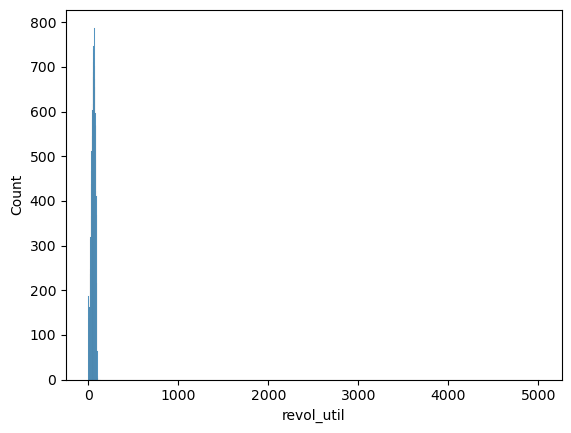

In [369]:
#outliers in revol_util and total_rec_late_fee?
sns.histplot(x='revol_util',data=df)
plt.show()

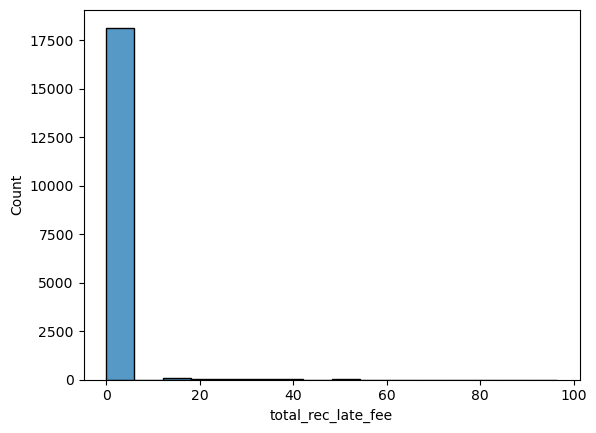

In [370]:
sns.histplot(x='total_rec_late_fee',data=df)
plt.show()

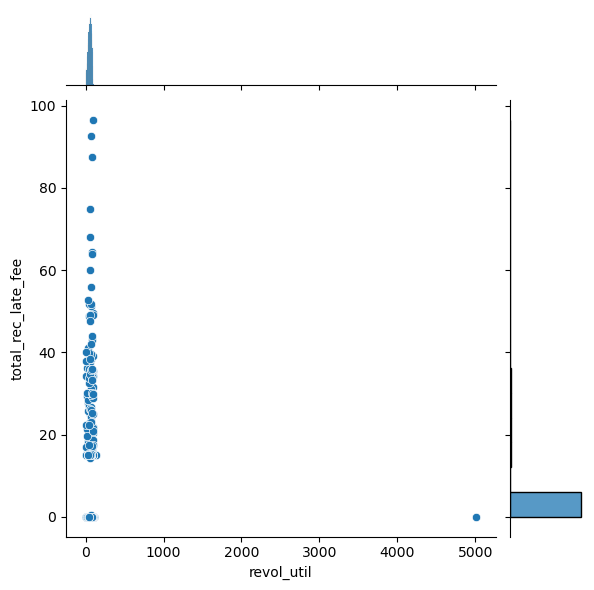

In [371]:
#outliers in revol_util and total_rec_late_fee?
sns.jointplot(x='revol_util',y='total_rec_late_fee',data=df);
plt.show()

In [372]:
df.revol_util.nlargest(10)

100      5010.0
2643      128.1
7880      112.9
19809     109.1
11712     107.7
7208      106.9
16563     106.1
12516     105.8
4948      105.3
17394     103.5
Name: revol_util, dtype: float64

In [373]:
df = df[df.revol_util!=df.revol_util.nlargest(10).iloc[0]]
df.shape

(18370, 14)

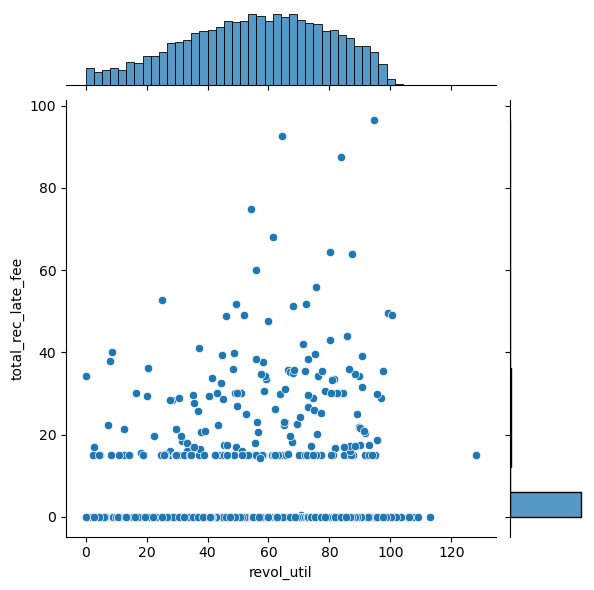

In [374]:
sns.jointplot(x='revol_util',y='total_rec_late_fee',data=df);

In [375]:
df.reset_index(drop=True, inplace=True)

In [376]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18370 entries, 0 to 18369
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    18370 non-null  int64  
 1   grade                 18370 non-null  object 
 2   annual_income         18370 non-null  int64  
 3   short_employee        18370 non-null  int64  
 4   emp_length_num        18370 non-null  int64  
 5   home_ownership        18370 non-null  object 
 6   Debt-To-Income Ratio  18370 non-null  float64
 7   purpose               18370 non-null  object 
 8   term                  18370 non-null  object 
 9   last_delinq_none      18370 non-null  object 
 10  revol_util            18370 non-null  float64
 11  total_rec_late_fee    18370 non-null  float64
 12  od_ratio              18370 non-null  float64
 13  bad_loan              18370 non-null  int64  
dtypes: float64(4), int64(5), object(5)
memory usage: 2.0+ MB


In [378]:
df.to_csv('df_after_cleaning.csv', index=False)

Loan default is a rare case:

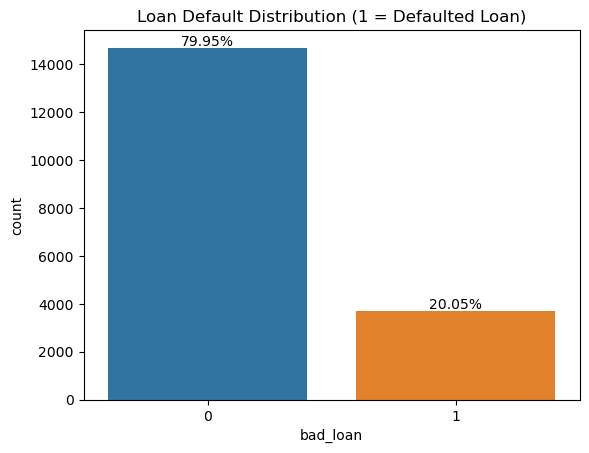

In [278]:
total_count = df.bad_loan.size

ax = sns.countplot(x='bad_loan', data=df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 100, f'{height/total_count*100:.2f}%', ha='center')

plt.title('Loan Default Distribution (1 = Defaulted Loan)')
plt.show()

### Visualization of Categorical Features' Distributions

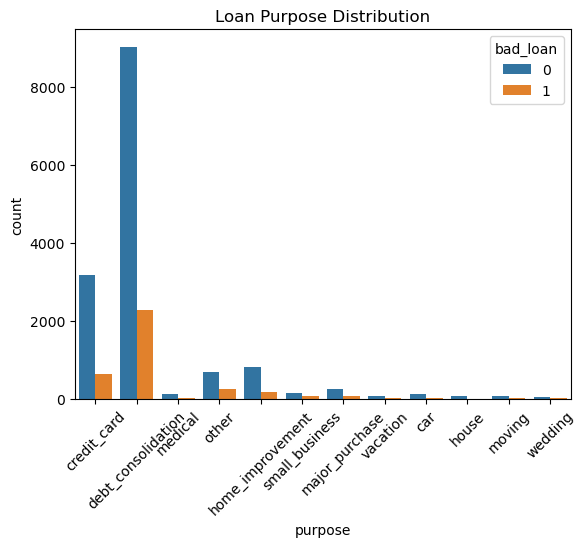

In [279]:
sns.countplot(x=df.purpose, hue=df.bad_loan);
plt.xticks(rotation=45)
plt.title('Loan Purpose Distribution');

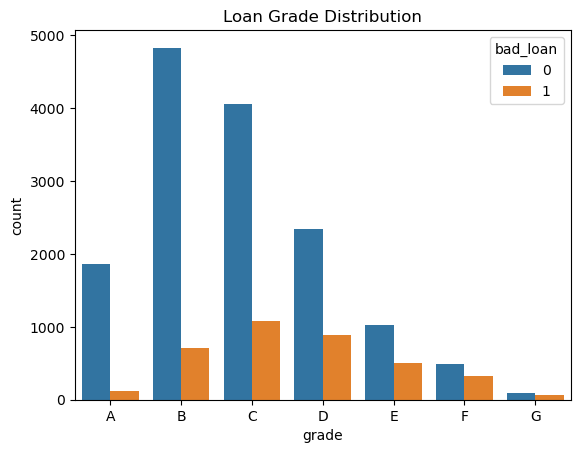

In [280]:
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
sns.countplot(x=df.grade, hue=df.bad_loan, order=grade_order);
plt.title('Loan Grade Distribution');

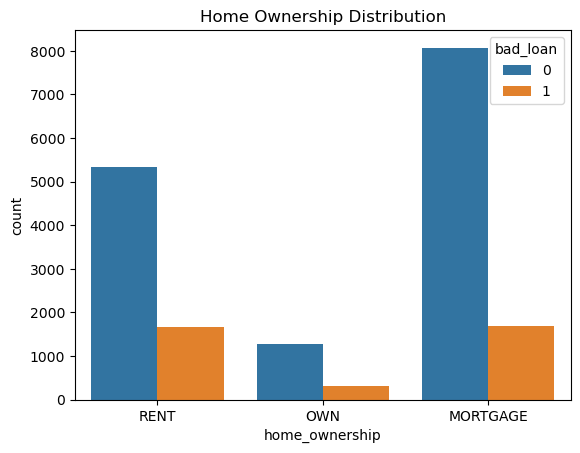

In [281]:
sns.countplot(x=df.home_ownership, hue=df.bad_loan);
plt.title('Home Ownership Distribution');

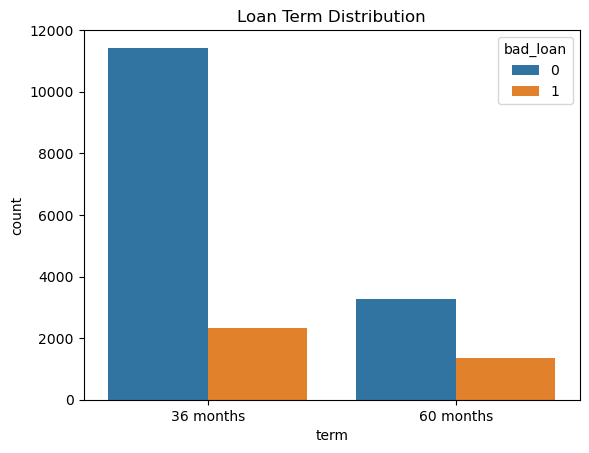

In [282]:
sns.countplot(x=df.term, hue=df.bad_loan);
plt.title('Loan Term Distribution');

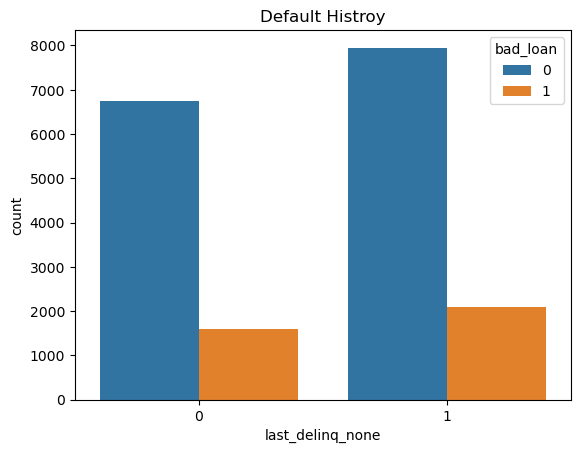

In [283]:
#Last _ delinq _ none - 1 when the debit has been in default at least once.
sns.countplot(x=df.last_delinq_none, hue=df.bad_loan);
plt.title('Default Histroy');

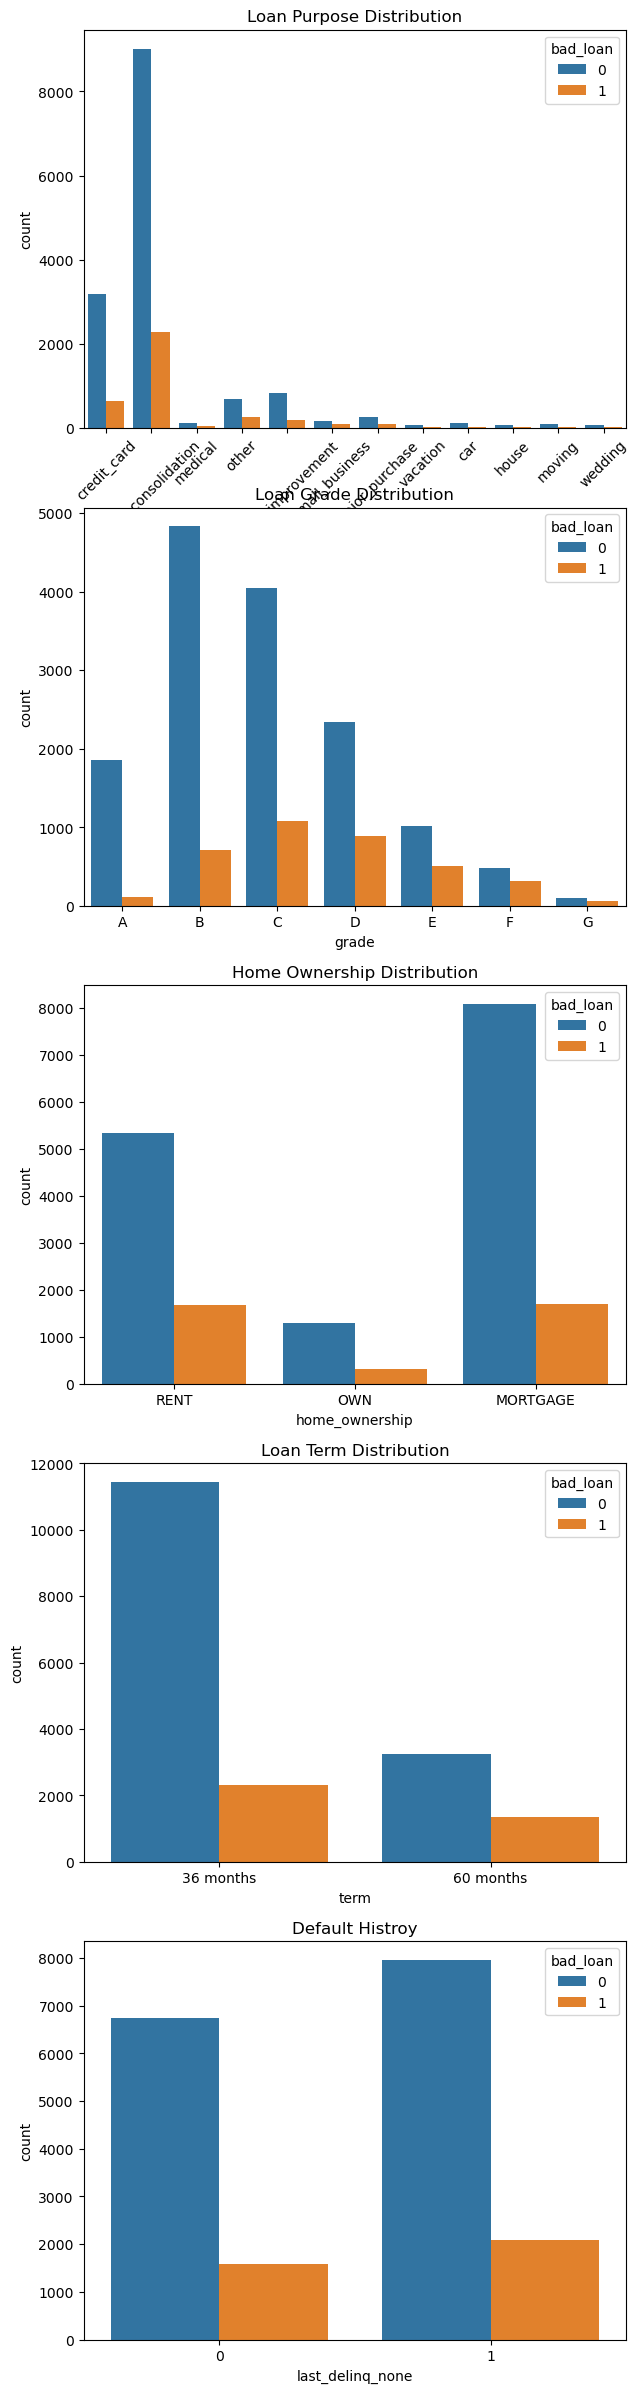

In [284]:
fig,ax = plt.subplots(5,1,figsize=(7,30))

sns.countplot(x=df.purpose, hue=df.bad_loan, ax=ax[0]);
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax[0].set_title('Loan Purpose Distribution');

sns.countplot(x=df.grade, hue=df.bad_loan, order=grade_order, ax=ax[1]);
ax[1].set_title('Loan Grade Distribution');

sns.countplot(x=df.home_ownership, hue=df.bad_loan, ax=ax[2]);
ax[2].set_title('Home Ownership Distribution');

sns.countplot(x=df.term, hue=df.bad_loan, ax=ax[3]);
ax[3].set_title('Loan Term Distribution');

sns.countplot(x=df.last_delinq_none, hue=df.bad_loan, ax=ax[4]);
ax[4].set_title('Default Histroy');


### Visualization of Continuous Features' Distributions

Histograms

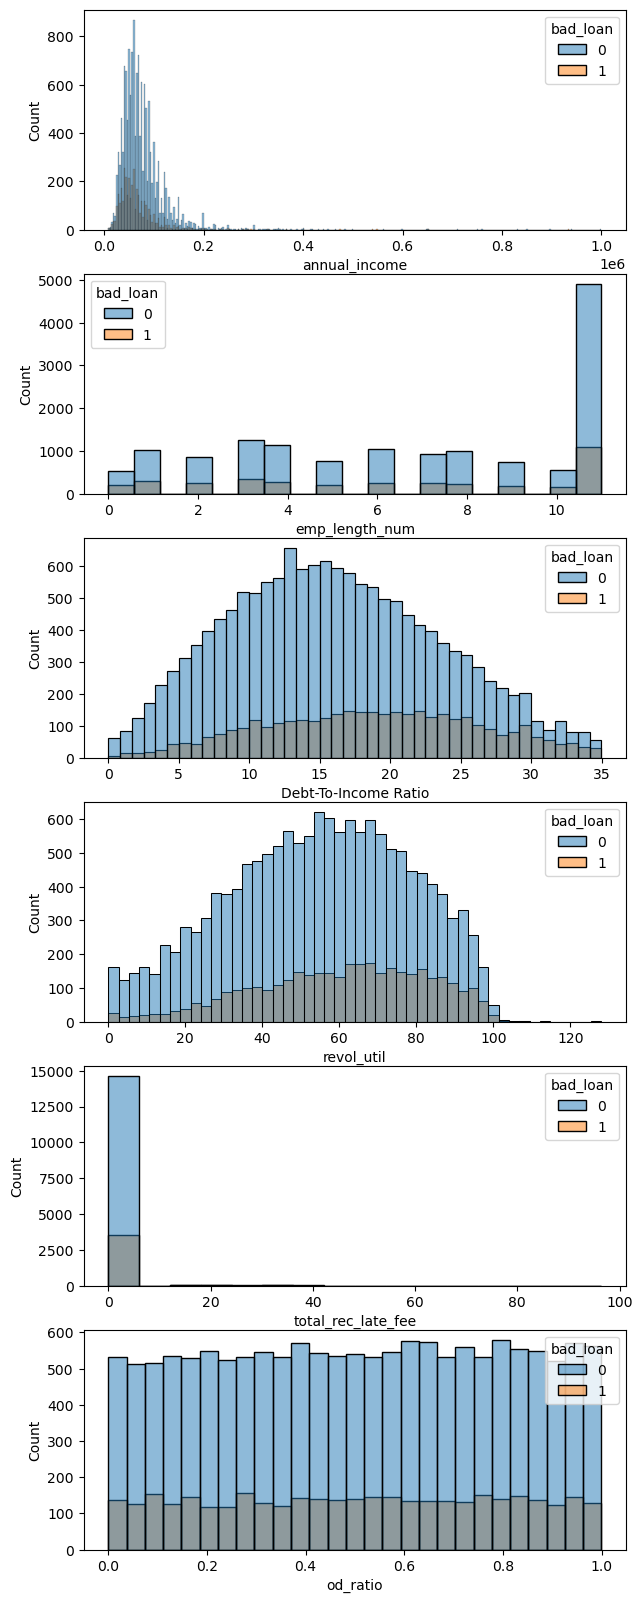

In [285]:
fig,ax = plt.subplots(6,1,figsize=(7,20))

sns.histplot(x='annual_income',
                hue = 'bad_loan', 
                data=df, 
                ax=ax[0]);

sns.histplot(x='emp_length_num',
                hue = 'bad_loan', 
                data=df, 
                ax=ax[1]);

sns.histplot(x='Debt-To-Income Ratio',
                hue = 'bad_loan', 
                data=df, 
                ax=ax[2]);

sns.histplot(x='revol_util',
                hue = 'bad_loan', 
                data=df, 
                ax=ax[3]);

sns.histplot(x='total_rec_late_fee',
                hue = 'bad_loan', 
                data=df, 
                ax=ax[4]);

sns.histplot(x='od_ratio',
                hue = 'bad_loan', 
                data=df, 
                ax=ax[5]);

Boxplots

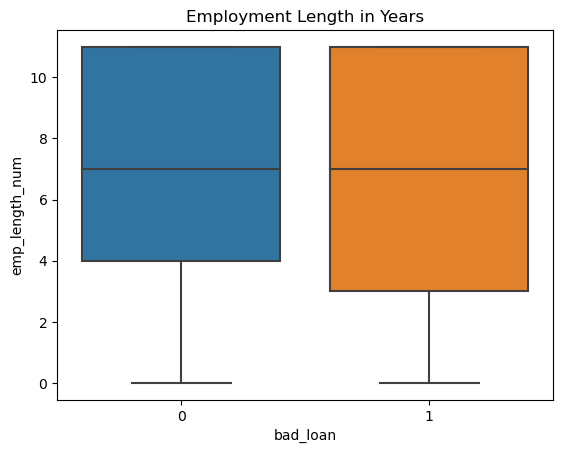

In [286]:
sns.boxplot(y='emp_length_num',
                x ='bad_loan',
                data=df);
plt.title('Employment Length in Years')
plt.show()

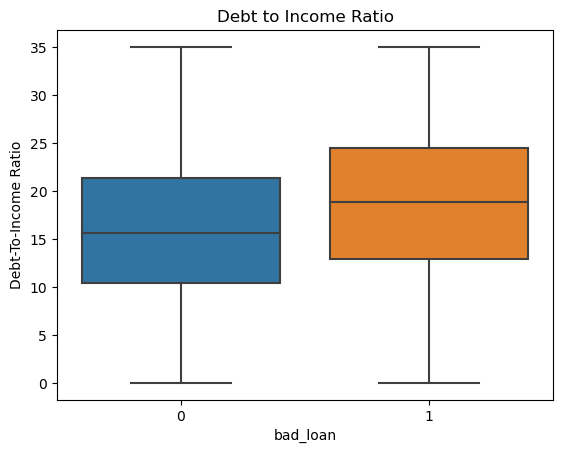

In [287]:
sns.boxplot(y='Debt-To-Income Ratio',
                x='bad_loan',
                data=df);
plt.title('Debt to Income Ratio')
plt.show()

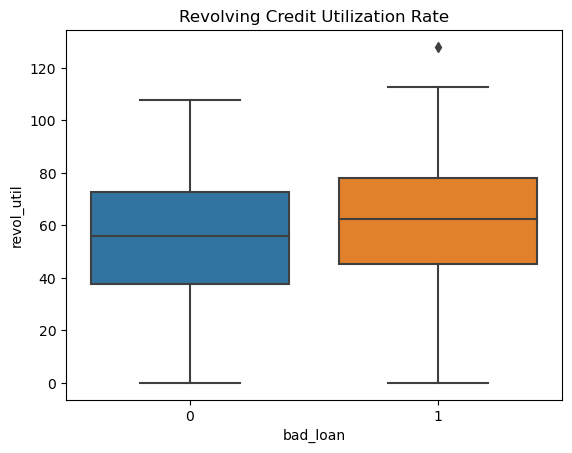

In [288]:
sns.boxplot(y='revol_util',
                x = 'bad_loan', 
                data=df);
plt.title('Revolving Credit Utilization Rate')
plt.show()

In [289]:
df.total_rec_late_fee[df.total_rec_late_fee != 0].sort_values()

10246     0.0100
8570      0.0100
12960     0.3500
14721    14.2350
3456     14.9394
          ...   
9672     68.1100
12936    74.9400
7201     87.5200
12709    92.5200
16034    96.4666
Name: total_rec_late_fee, Length: 212, dtype: float64

In [290]:
total_rec_late_fee_not0_df = df[df.total_rec_late_fee != 0]
total_rec_late_fee_0_df = df[df.total_rec_late_fee == 0]

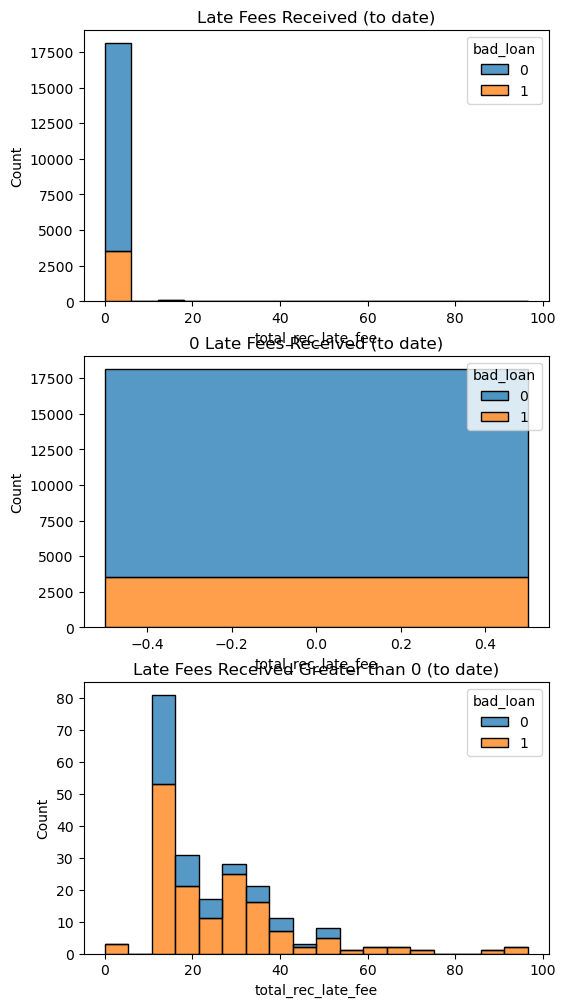

In [291]:
fig,ax = plt.subplots(3,1,figsize=(6,12))

sns.histplot(x='total_rec_late_fee',
             hue = 'bad_loan', 
             data=df,
             multiple="stack",
             ax=ax[0]);
ax[0].set_title('Late Fees Received (to date)');

#0 late fee
sns.histplot(x='total_rec_late_fee',
             hue = 'bad_loan', 
             data=total_rec_late_fee_0_df,
             multiple="stack",
             ax=ax[1]);
ax[1].set_title('0 Late Fees Received (to date)');

#'zoom in' to late fees that are not zero
sns.histplot(x='total_rec_late_fee',
             hue = 'bad_loan', 
             data=total_rec_late_fee_not0_df,
             multiple="stack",
             ax=ax[2]);
ax[2].set_title('Late Fees Received Greater than 0 (to date)');

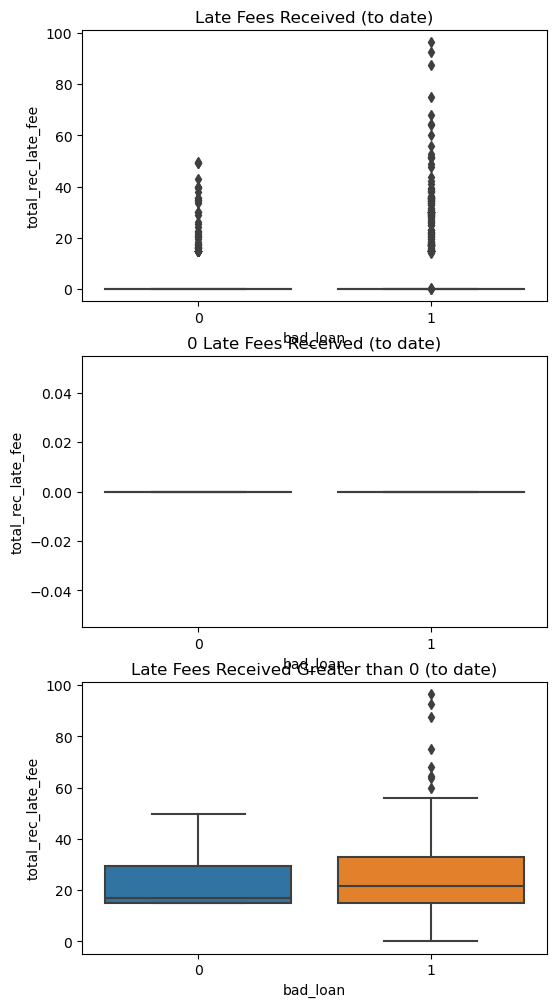

In [292]:
fig,ax = plt.subplots(3,1,figsize=(6,12))

sns.boxplot(y='total_rec_late_fee',
            x = 'bad_loan', 
            data=df,
            ax=ax[0]);
ax[0].set_title('Late Fees Received (to date)');

#0 late fee
sns.boxplot(y='total_rec_late_fee',
            x = 'bad_loan', 
            data=total_rec_late_fee_0_df,
            ax=ax[1]);
ax[1].set_title('0 Late Fees Received (to date)');

#'zoom in' to late fees that are not zero
sns.boxplot(y='total_rec_late_fee',
            x = 'bad_loan', 
            data=total_rec_late_fee_not0_df,
            ax=ax[2]);
ax[2].set_title('Late Fees Received Greater than 0 (to date)');

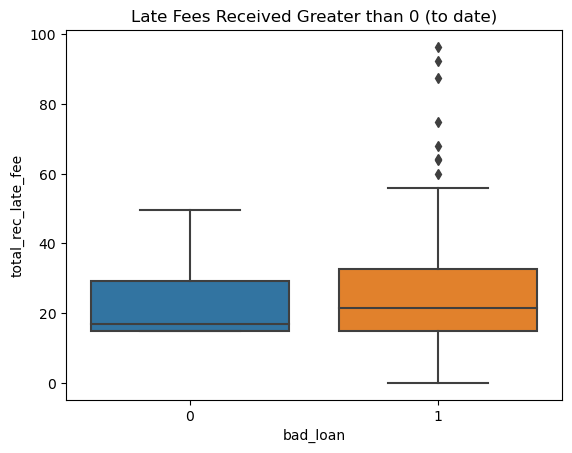

In [303]:
sns.boxplot(y='total_rec_late_fee',
            x = 'bad_loan', 
            data=total_rec_late_fee_not0_df);
plt.title('Late Fees Received Greater than 0 (to date)');

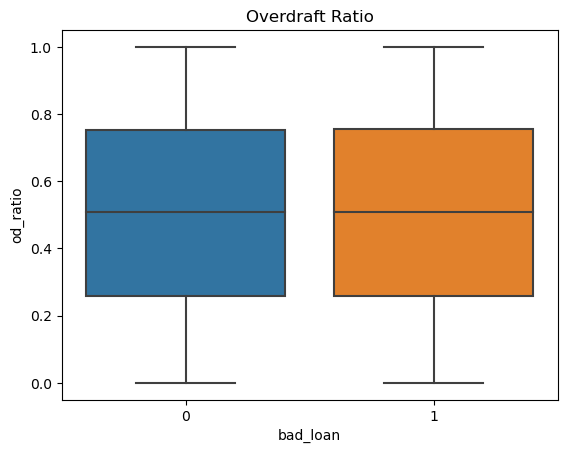

In [293]:
sns.boxplot(y='od_ratio',
                x = 'bad_loan', 
                data=df);
plt.title('Overdraft Ratio')
plt.show()

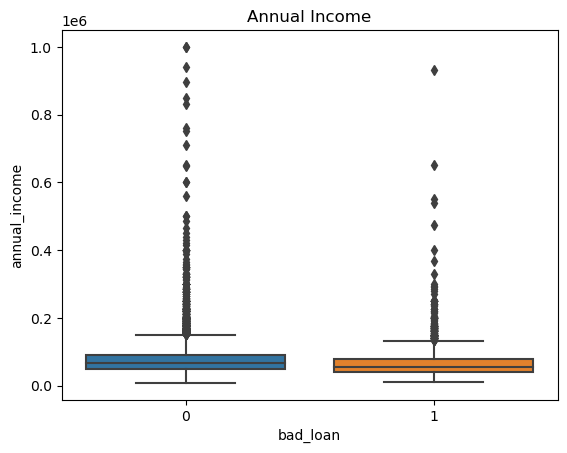

In [294]:
sns.boxplot(y='annual_income',
                x = 'bad_loan', 
                data=df);
plt.title('Annual Income')
plt.show()

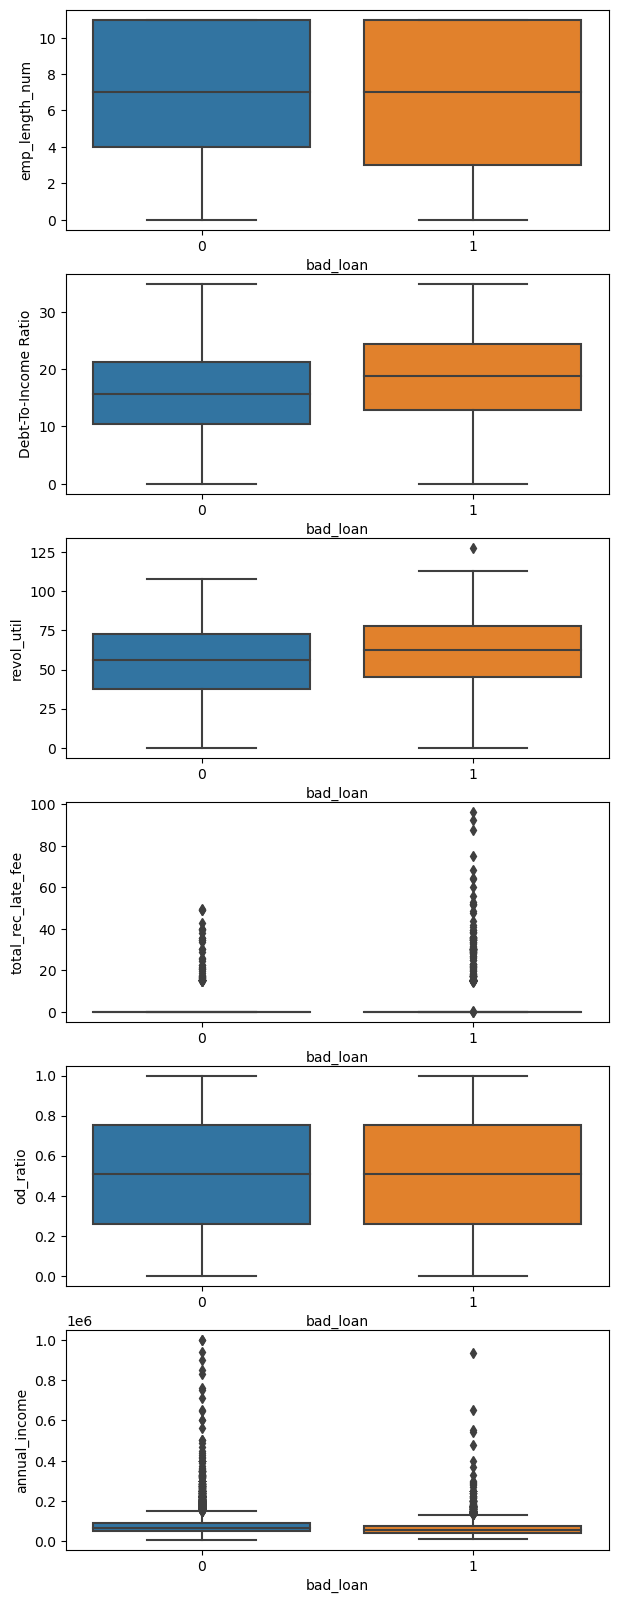

In [295]:
fig,ax = plt.subplots(6,1,figsize=(7,20))

#sns.boxplot(x=df.emp_length_num, y=df.bad_loan, ax=ax[0]);

sns.boxplot(y='emp_length_num',
                x ='bad_loan',
                data=df, 
                ax=ax[0]);

sns.boxplot(y='Debt-To-Income Ratio',
                x='bad_loan',
                data=df, 
                ax=ax[1]);

sns.boxplot(y='revol_util',
                x = 'bad_loan', 
                data=df, 
                ax=ax[2]);

sns.boxplot(y='total_rec_late_fee',
                x = 'bad_loan', 
                data=df, 
                ax=ax[3]);

sns.boxplot(y='od_ratio',
                x = 'bad_loan', 
                data=df, 
                ax=ax[4]);

sns.boxplot(y='annual_income',
                x = 'bad_loan', 
                data=df, 
                ax=ax[5]);

### Data Cleaning - Dealing With Skew

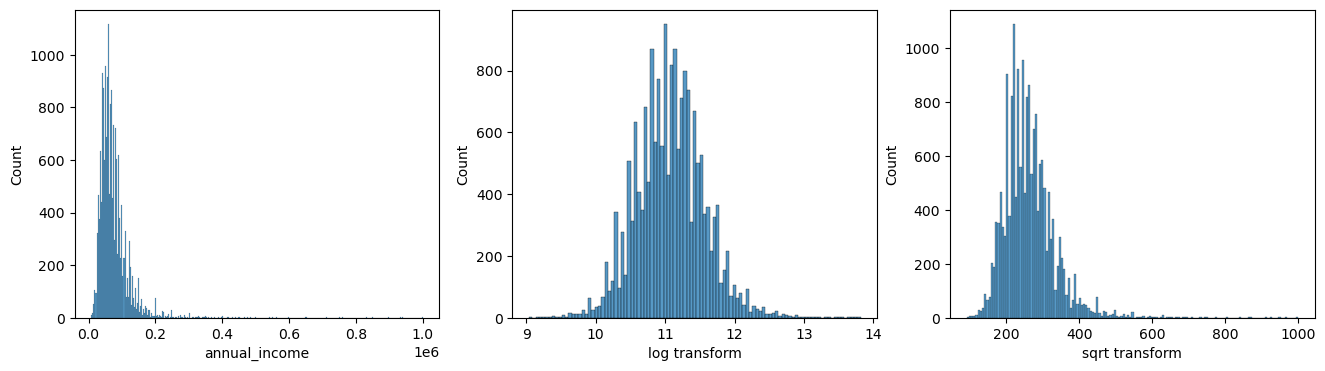

In [296]:
#annual_income looks very skewed. Try trainsforming the feature using log or sqrt

fig, ax = plt.subplots(1, 3, figsize = (16,4))
sns.histplot(x=df.annual_income, ax=ax[0]);
sns.histplot(x=df.annual_income.apply(lambda x: x+1).apply(np.log), ax=ax[1]);
ax[1].set_xlabel('log transform');
sns.histplot(x=df.annual_income.apply(np.sqrt), ax=ax[2]);
ax[2].set_xlabel('sqrt transform');

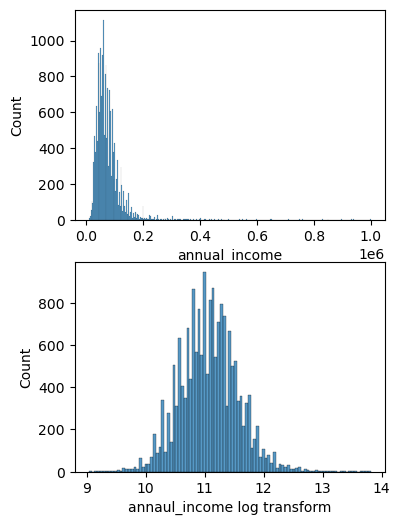

In [309]:
fig, ax = plt.subplots(2, 1, figsize = (4,6))
sns.histplot(x=df.annual_income, ax=ax[0]);
sns.histplot(x=df.annual_income.apply(lambda x: x+1).apply(np.log), ax=ax[1]);
ax[1].set_xlabel('annaul_income log transform');

In [297]:
df['annual_income_log'] = df.annual_income.apply(lambda x: x+1).apply(np.log)

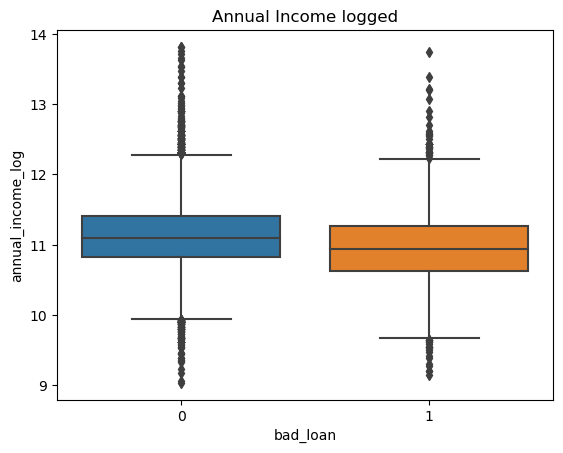

In [305]:
sns.boxplot(y='annual_income_log',
                x = 'bad_loan', 
                data=df);
plt.title('Annual Income logged')
plt.show()

In [298]:
df.to_csv('Loan_Dataset_3.csv', index=False)

### Feature Engineering - One-Hot Encoding

In [201]:
pd.get_dummies(df).shape

/Users/kaimihuang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


(18370, 36)

In [202]:
pd.get_dummies(df).columns

/Users/kaimihuang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


Index(['id', 'annual_income', 'short_employee', 'emp_length_num',
       'Debt-To-Income Ratio', 'revol_util', 'total_rec_late_fee', 'od_ratio',
       'bad_loan', 'annual_income_log', 'grade_A', 'grade_B', 'grade_C',
       'grade_D', 'grade_E', 'grade_F', 'grade_G', 'home_ownership_MORTGAGE',
       'home_ownership_OWN', 'home_ownership_RENT', 'purpose_car',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_small_business', 'purpose_vacation', 'purpose_wedding',
       'term_36 months', 'term_60 months', 'last_delinq_none_0',
       'last_delinq_none_1'],
      dtype='object')

In [203]:
df = pd.get_dummies(df)

/Users/kaimihuang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [204]:
df.to_csv('Loan_Dataset_2.csv', index=False)

In [205]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, log_loss, recall_score, accuracy_score, classification_report, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, auc

In [206]:
X = df.drop(columns=['id', 'annual_income','bad_loan','grade_A',
                     'home_ownership_MORTGAGE','purpose_car','term_36 months',
                     'last_delinq_none_0'])

#1 represents bad loan. 0 represents good loan
y = df['bad_loan'].astype(int)

In [247]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18370 entries, 0 to 18369
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   short_employee              18370 non-null  int64  
 1   emp_length_num              18370 non-null  int64  
 2   Debt-To-Income Ratio        18370 non-null  float64
 3   revol_util                  18370 non-null  float64
 4   total_rec_late_fee          18370 non-null  float64
 5   od_ratio                    18370 non-null  float64
 6   annual_income_log           18370 non-null  float64
 7   grade_B                     18370 non-null  uint8  
 8   grade_C                     18370 non-null  uint8  
 9   grade_D                     18370 non-null  uint8  
 10  grade_E                     18370 non-null  uint8  
 11  grade_F                     18370 non-null  uint8  
 12  grade_G                     18370 non-null  uint8  
 13  home_ownership_OWN          183

In [207]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=123)
train_ind, test_ind = next(sss.split(X,y,groups=None))
X_train, y_train, X_test, y_test = X.iloc[train_ind], y.iloc[train_ind], X.iloc[test_ind], y.iloc[test_ind]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [208]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}

In [311]:
def get_metrics(target_test, target_score, target_pred):
    precision, recall, thresholds = precision_recall_curve(target_test, target_score)
    fpr, tpr, thresholds = roc_curve(target_test, target_score)
    pr_auc = average_precision_score(target_test, target_score)
    roc_auc = auc(fpr, tpr)
    accuracy = accuracy_score(target_test, target_pred)
    
    print(f'PR AUC is {pr_auc:.2f}. ROC AUC is {roc_auc:.2f}, Accuracy is {accuracy:.2f}')
    return precision, recall, pr_auc, fpr, tpr, roc_auc

def get_confusion_matrix(target_test, target_pred):
    matrix = confusion_matrix(target_test, target_pred)
    df = pd.DataFrame(matrix, index=['Actual Negative', 'Actual Positive'], 
                 columns=['Predicted Negative', 'Predicted Positive'])
    return df

### Logistic Regression

In [312]:
param_grid = [{'C': [1, 10, 100, 1000]}]

lg_clf = LogisticRegression(class_weight='balanced',
                            random_state = 123
                           )
     
grid_search = GridSearchCV(lg_clf, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)
               
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'C': 10}

In [313]:
lg_clf = grid_search.best_estimator_
lg_clf.fit(X_train, y_train)
y_pred = lg_clf.predict(X_test)
y_score = lg_clf.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,1922,1015
Actual Positive,244,493


In [315]:
lg_precision, lg_recall, lg_pr_auc, lg_fpr, lg_tpr, lg_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.39. ROC AUC is 0.71, Accuracy is 0.66


In [316]:
lg_clf.coef_

array([[ 0.05724749, -0.02744488,  0.25226778,  0.12562517,  0.31722817,
        -0.00267831, -0.29932582,  0.24593979,  0.44037519,  0.49064977,
         0.40981092,  0.35107488,  0.15534084, -0.02012119,  0.0927453 ,
        -0.06301353, -0.04536323,  0.06110605, -0.03849221,  0.06199869,
        -0.01128224, -0.01218679,  0.02016083,  0.04312443, -0.00276218,
        -0.01672567,  0.16912878,  0.04046431]])

### XGBoost

In [317]:
param_grid = [
    {'n_estimators': [94, 95, 96],
     'max_depth': [1,2, 3, 4],
     'learning_rate': [0.01, 0.1, 1]}]

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic',
                                    eval_metric='logloss',
                                    scale_pos_weight=class_weights[0]/class_weights[1],
                                    random_state = 123)

grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 95}

In [318]:
xgb_classifier = grid_search.best_estimator_
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)
y_score = xgb_classifier.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,2933,4
Actual Positive,725,12


In [319]:
xgb_precision, xgb_recall, xgb_pr_auc, xgb_fpr, xgb_tpr, xgb_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.38. ROC AUC is 0.70, Accuracy is 0.80


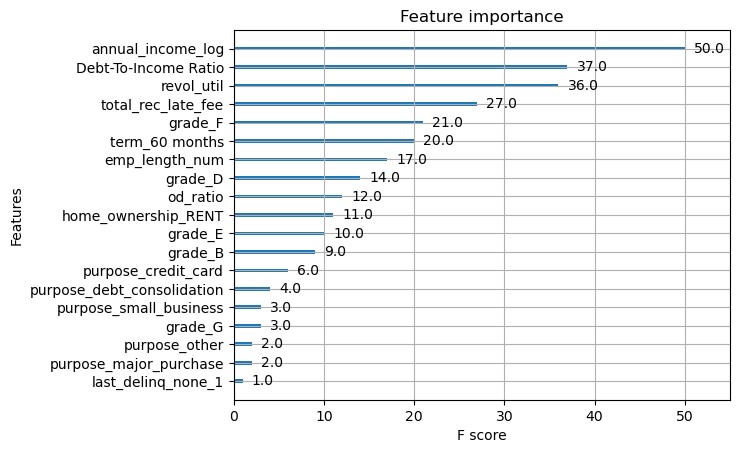

In [321]:
xgb_classifier.get_booster().feature_names =  list(X.columns)
xgb.plot_importance(xgb_classifier);

### Random Forest

In [322]:
param_grid = [
    {'n_estimators': [440, 450, 460],
     'max_depth': [5, 10, 15]}
]

rf_classifier = RandomForestClassifier(class_weight=class_weights,
                                       random_state = 123)

grid_search = GridSearchCV(rf_classifier, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'max_depth': 5, 'n_estimators': 450}

In [323]:
best_params = grid_search.best_estimator_
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
y_score = rf_classifier.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,2890,47
Actual Positive,687,50


In [324]:
rf_precision, rf_recall, rf_pr_auc, rf_fpr, rf_tpr, rf_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.33. ROC AUC is 0.66, Accuracy is 0.80


In [325]:
feature_names = list(X.columns)
feature_importances = list()

for name, score in zip(feature_names, rf_classifier.feature_importances_):
    p = (name, score)
    feature_importances.append(p)

feature_importances = sorted(feature_importances, key=lambda x:x[1],reverse=True)
feature_importances

[('Debt-To-Income Ratio', 0.1833648062110765),
 ('revol_util', 0.17020943198427374),
 ('annual_income_log', 0.16402277356907907),
 ('od_ratio', 0.16090261849089846),
 ('emp_length_num', 0.0799293381995242),
 ('last_delinq_none_1', 0.02519365574633562),
 ('term_60 months', 0.02505008001902796),
 ('home_ownership_RENT', 0.020323411351521718),
 ('grade_B', 0.018751550885723924),
 ('purpose_debt_consolidation', 0.017155292024823982),
 ('grade_D', 0.015208926808018393),
 ('total_rec_late_fee', 0.01441600930767856),
 ('purpose_credit_card', 0.013830429950602139),
 ('grade_C', 0.013532733235339302),
 ('grade_E', 0.011890822598733645),
 ('home_ownership_OWN', 0.011647507212764547),
 ('grade_F', 0.009887923507438548),
 ('short_employee', 0.009568372264843783),
 ('purpose_home_improvement', 0.007739512796775708),
 ('purpose_other', 0.0074380613024212046),
 ('purpose_major_purchase', 0.0047342739002003975),
 ('purpose_small_business', 0.0038561595883484126),
 ('grade_G', 0.002800816677812148),
 (

### Gradient Descent Optimization

Stochastic Gradient Descent

In [326]:
param_grid = [
    {'max_iter': list(range(50, 951, 100))}
]

sgd_clf = SGDClassifier(loss='log', 
                        learning_rate='optimal',
                        tol=1e-3,
                        class_weight=class_weights,
                        random_state = 123)

grid_search = GridSearchCV(sgd_clf, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'max_iter': 150}

In [327]:
sgd_clf = grid_search.best_estimator_
sgd_clf.fit(X_train, y_train)
y_pred = sgd_clf.predict(X_test)
y_score = sgd_clf.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,1736,1201
Actual Positive,249,488


In [328]:
sgd_precision, sgd_recall, sgd_pr_auc, sgd_fpr, sgd_tpr, sgd_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.34. ROC AUC is 0.67, Accuracy is 0.61


Mini-batch Gradient Descent

In [329]:
### from sklearn.base import clone

batch_size = 150
sample_size = len(X_train)

#set aside a validation batch for mini-batch SGD
sss_2 = StratifiedShuffleSplit(n_splits=1, test_size=batch_size, train_size=sample_size-batch_size)
train_ind, val_ind = next(sss_2.split(X_train, y_train))
X_train_2, y_train_2, X_mini_val, y_mini_val = X_train[list(train_ind)], y_train.iloc[train_ind], X_train[list(val_ind)], y_train.iloc[val_ind]
y_train_2 = y_train_2.to_numpy().reshape(-1,1)
combined_training_data = np.concatenate((X_train_2, y_train_2), axis = 1)

minimum_val_error = float("inf") 
best_model = None

for i in range(100):
    
    np.random.shuffle(combined_training_data)
    
    X_mini_train = combined_training_data[0:batch_size, :-1]
    y_mini_train = combined_training_data[0:batch_size, -1]
                                          
    sgd_clf.partial_fit(X_mini_train, y_mini_train, classes=np.unique(y_train_2))
    y_val_proba = sgd_clf.predict_proba(X_mini_val)
    val_error = log_loss(y_mini_val, y_val_proba)
    
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_model = clone(sgd_clf)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_score = best_model.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)


,Predicted Negative,Predicted Positive
Actual Negative,1736,1201
Actual Positive,249,488


In [330]:
mbgd_precision, mbgd_recall, mbgd_pr_auc, mbgd_fpr, mbgd_tpr, mbgd_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.34. ROC AUC is 0.67, Accuracy is 0.61


### Support Vector Machine

Linear SVM

In [332]:
param_grid = [
    {'max_iter': np.arange(2, 8, 1),
     'C': np.arange(10, 20, 2)}
]

lin_svm_clf = LinearSVC(dual=False, 
                        loss='squared_hinge',
                        random_state=123,
                        class_weight='balanced')

grid_search = GridSearchCV(lin_svm_clf, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'C': 10, 'max_iter': 4}

In [333]:
from sklearn.calibration import CalibratedClassifierCV

lin_svm_clf = grid_search.best_estimator_
lin_svm_clf.fit(X_train, y_train)
y_pred = lin_svm_clf.predict(X_test)

clf = CalibratedClassifierCV(grid_search.best_estimator_) 
clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)[:,1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,1912,1025
Actual Positive,242,495


In [334]:
lsvm_precision, lsvm_recall, lsvm_pr_auc, lsvm_fpr, lsvm_tpr, lsvm_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.38. ROC AUC is 0.71, Accuracy is 0.66


Polynomial Kernel Support Vector Classifier

SVC's time complexity is O(n^2 xd) to O(n^3 xd). To lower the time required to train kernel SVM models, i will use a smaller training dataset

In [335]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.8, train_size=0.2, random_state=123)
train_ind, test_ind = next(sss.split(X,y,groups=None))
X_train_2, y_train_2, X_test_2, y_test_2 = X.iloc[train_ind], y.iloc[train_ind], X.iloc[test_ind], y.iloc[test_ind]

scaler = StandardScaler()
X_train_2 = scaler.fit_transform(X_train_2)
X_test_2 = scaler.transform(X_test_2)

In [336]:
param_grid = [
    {'degree': [0, 1, 2],
     'coef0': [1, 2],
     'C': [1, 10, 100]}
]

poly_kernel_svm_clf = SVC(kernel = 'poly',
                          probability = True,
                          class_weight=class_weights)

grid_search = GridSearchCV(poly_kernel_svm_clf, param_grid, cv=2,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train_2, y_train_2)

grid_search.best_params_

{'C': 1, 'coef0': 2, 'degree': 1}

In [337]:
poly_kernel_svm_clf = grid_search.best_estimator_
poly_kernel_svm_clf.fit(X_train_2, y_train_2)
y_pred = poly_kernel_svm_clf.predict(X_test_2)
y_score = poly_kernel_svm_clf.predict_proba(X_test_2)[:, 1]

get_confusion_matrix(y_test_2, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,7599,4151
Actual Positive,1013,1933


In [338]:
pksvm_precision, pksvm_recall, pksvm_pr_auc, pksvm_fpr, pksvm_tpr, pksvm_roc_auc = get_metrics(y_test_2, y_score, y_pred)

PR AUC is 0.37. ROC AUC is 0.70, Accuracy is 0.65


Gaussian RBF Kernel Support Vector Classifier

In [339]:
param_grid = [
    {'gamma': [0.001, 0.01, 0.1, 1],
     'C': [0.1, 1, 10, 100, 1000]}
]
#https://scikit-learn.org/stable/modules/svm.html#svm-kernels
rbf_kernel_svm_clf = SVC(kernel = 'rbf',
                         probability = True,
                         class_weight=class_weights)

grid_search = GridSearchCV(rbf_kernel_svm_clf, param_grid, cv=2,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train_2, y_train_2)

grid_search.best_params_

{'C': 0.1, 'gamma': 0.001}

In [340]:
rbf_kernel_svm_clf = grid_search.best_estimator_
rbf_kernel_svm_clf.fit(X_train_2, y_train_2)
y_pred = rbf_kernel_svm_clf.predict(X_test_2)
y_score = rbf_kernel_svm_clf.predict_proba(X_test_2)[:, 1]

get_confusion_matrix(y_test_2, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,9262,2488
Actual Positive,1575,1371


In [341]:
rbfksvm_precision, rbfksvm_recall, rbfksvm_pr_auc, rbfksvm_fpr, rbfksvm_tpr, rbfksvm_roc_auc = get_metrics(y_test_2, y_score, y_pred)

PR AUC is 0.36. ROC AUC is 0.69, Accuracy is 0.72


### Stacking/Stacked Generalization

In [342]:
base_learners = [
    ('rf', rf_classifier),
    ('sgd', sgd_clf),
    ('xgb', xgb_classifier),
]

meta_learner = LogisticRegression(class_weight=class_weights)

stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)
y_score = stacking_model.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,1910,1027
Actual Positive,266,471


In [343]:
stack_precision, stack_recall, stack_pr_auc, stack_fpr, stack_tpr, stack_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.37. ROC AUC is 0.69, Accuracy is 0.65


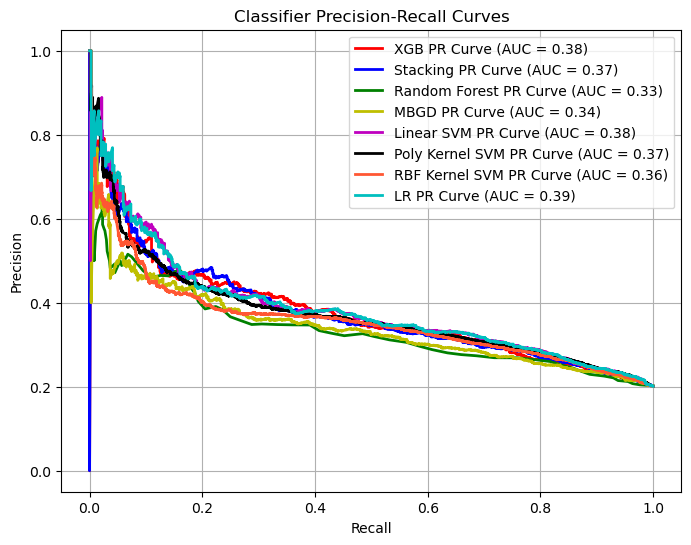

In [344]:
plt.figure(figsize=(8, 6))


plt.plot(xgb_recall, xgb_precision, color='r', lw=2, label=f'XGB PR Curve (AUC = {xgb_pr_auc:.2f})')
plt.plot(stack_recall, stack_precision, color='b', lw=2, label=f'Stacking PR Curve (AUC = {stack_pr_auc:.2f})')
plt.plot(rf_recall, rf_precision, color='g', lw=2, label=f'Random Forest PR Curve (AUC = {rf_pr_auc:.2f})')
plt.plot(mbgd_recall, mbgd_precision, color='y', lw=2, label=f'MBGD PR Curve (AUC = {mbgd_pr_auc:.2f})')
plt.plot(lsvm_recall, lsvm_precision, color='m', lw=2, label=f'Linear SVM PR Curve (AUC = {lsvm_pr_auc:.2f})')
plt.plot(pksvm_recall, pksvm_precision, color='k', lw=2, label=f'Poly Kernel SVM PR Curve (AUC = {pksvm_pr_auc:.2f})')
plt.plot(rbfksvm_recall, rbfksvm_precision, color='#FF5733', lw=2, label=f'RBF Kernel SVM PR Curve (AUC = {rbfksvm_pr_auc:.2f})')
plt.plot(lg_recall, lg_precision, color='c', lw=2, label=f'LR PR Curve (AUC = {lg_pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Classifier Precision-Recall Curves')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

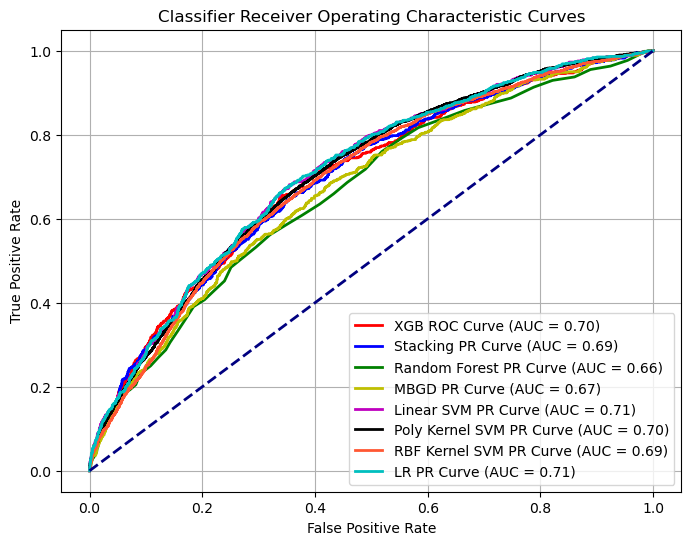

In [345]:
plt.figure(figsize=(8, 6))

plt.plot(xgb_fpr, xgb_tpr, color='r', lw=2, label=f'XGB ROC Curve (AUC = {xgb_roc_auc:.2f})')
plt.plot(stack_fpr, stack_tpr, color='b', lw=2, label=f'Stacking PR Curve (AUC = {stack_roc_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, color='g', lw=2, label=f'Random Forest PR Curve (AUC = {rf_roc_auc:.2f})')
plt.plot(mbgd_fpr, mbgd_tpr, color='y', lw=2, label=f'MBGD PR Curve (AUC = {mbgd_roc_auc:.2f})')
plt.plot(lsvm_fpr, lsvm_tpr, color='m', lw=2, label=f'Linear SVM PR Curve (AUC = {lsvm_roc_auc:.2f})')
plt.plot(pksvm_fpr, pksvm_tpr, color='k', lw=2, label=f'Poly Kernel SVM PR Curve (AUC = {pksvm_roc_auc:.2f})')
plt.plot(rbfksvm_fpr, rbfksvm_tpr, color='#FF5733', lw=2, label=f'RBF Kernel SVM PR Curve (AUC = {rbfksvm_roc_auc:.2f})')
plt.plot(lg_fpr, lg_tpr, color='c', lw=2, label=f'LR PR Curve (AUC = {lg_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifier Receiver Operating Characteristic Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()